# Génération du Labyrinthe

> L'objectif de ce notebook est d'entrainer un modèle à générer des labyrinthes complexes et infinis en utilisant les cartes d'exemple disponibles dans ce même répertoire.

## Génération du dataset

Dans un premier temps, nous cherchons à obtenir un dataset de la forme suivante :
$$
\text{Voisinage} \rightarrow \text{Case}
$$
Pour ce faire, nous allons reprendre l'idée des filtres de convolution et balayer le labyrinthe avec un filtre de taille $n\times n$.

In [26]:
# -------------------------- CHARGEMENT DES DONNEES -------------------------- #
import pandas as pd
import os
from IPython.display import display, Markdown

data = {}
for root, dirs, files in os.walk("."):
    for filename in files:
        if filename.endswith(".csv"):
            last_character = filename[-5]
            simple_filename = filename.split(".")[0]
            if simple_filename not in data:
                data[simple_filename] = {}
            if last_character not in data[simple_filename]:
                try:
                    csv = pd.read_csv(filename).to_numpy()
                except:
                    continue
                if csv.shape[0] * csv.shape[1] != 0:
                    data[simple_filename][last_character] = csv

for data_name in data:
    display(Markdown(f"-> **{data_name}** : *{len(data[data_name])} layers*"))

-> **training_map** : *1 layers*

-> **maze** : *1 layers*

In [27]:
# --------------------------- CREATON DES DATASETS --------------------------- #
import numpy as np


def create_dataset(data, window_size=5):
    # Add padding of size window_size // 2 with -1
    data = data.astype(str)
    data = np.pad(data, window_size, constant_values="border")
    dataset = pd.DataFrame(
        [
            data[i : i + window_size, j : j + window_size].flatten()
            for i in range(0, data.shape[0] - window_size + 1)
            for j in range(0, data.shape[1] - window_size + 1)
        ]
    )
    dataset["label"] = dataset[dataset.columns[(window_size**2 - 1) // 2]]
    dataset.drop(dataset.columns[(window_size**2 - 1) // 2], axis=1, inplace=True)
    dataset = dataset[dataset["label"] != "border"]
    dataset = dataset.replace("border", -1)
    dataset = dataset.astype(int)

    return dataset


datasets = {
    data_name: {
        last_character: create_dataset(data[data_name][last_character])
        for last_character in data[data_name]
    }
    for data_name in data
}
for dataset in datasets:
    for layer in datasets[dataset]:
        display(
            Markdown(
                f"-> **{dataset}** : *{layer} : {len(datasets[dataset][layer])} samples*"
            )
        )

-> **training_map** : *1 : 72 samples*

-> **maze** : *e : 870 samples*

In [28]:
# ------------------------------ TRAINING MODELS ----------------------------- #
from sklearn.ensemble import RandomForestClassifier

classifiers = {
    dataset: {
        layer: {
            "model": RandomForestClassifier(verbose=True, n_jobs=-1).fit(
                datasets[dataset][layer].drop("label", axis=1),
                datasets[dataset][layer]["label"],
            ),
            "window_size": int(np.sqrt(datasets[dataset][layer].shape[1])),
            # List of unique value in the dataframe
            "assets": dict(
                zip(
                    *np.unique(
                        datasets[dataset][layer].to_numpy().flatten(),
                        return_counts=True,
                    )
                )
            ),
        }
        for layer in datasets[dataset]
    }
    for dataset in datasets
}

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 20 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.2s finished


In [40]:
# ------------------------------ GENERATING MAZE ----------------------------- #
import numpy as np


def generate_maze(classifier: tuple, size: tuple, nbr_iter=10, temperature=0.1):
    # Unpack Arguments
    size_x, size_y = size
    window_size = classifier["window_size"]
    assets = classifier["assets"]
    model = classifier["model"]
    model.set_params(n_jobs=1)

    # Generate Maze
    ## Generate a matrix full of random values from the assets
    maze = np.random.choice(
        list(assets.keys()),
        (size_x + 2 * window_size, size_y + 2 * window_size),
        p=list(assets.values()) / np.sum(list(assets.values())),
    )

    # Apply the classifier on the maze
    for _ in range(nbr_iter):
        # Generate dataset from the maze
        dataset = create_dataset(maze, window_size).drop("label", axis=1)

        # Apply the classifier on the dataset
        logits = model.predict_proba(dataset)
        logits = logits ** (1 / temperature)
        predictions = np.array(
            [
                np.random.choice(model.classes_, p=logit / logit.sum())
                for logit in logits
            ]
        )

        # Recreate the maze from the predictions
        maze = np.array(predictions).reshape(
            size_x + 2 * window_size, size_y + 2 * window_size
        )

    return maze


maze = generate_maze(classifiers["training_map"]["1"], (30, 30))
# Save the maze as a csv file
np.savetxt("maze.csv", maze, delimiter=",", fmt="%d")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s


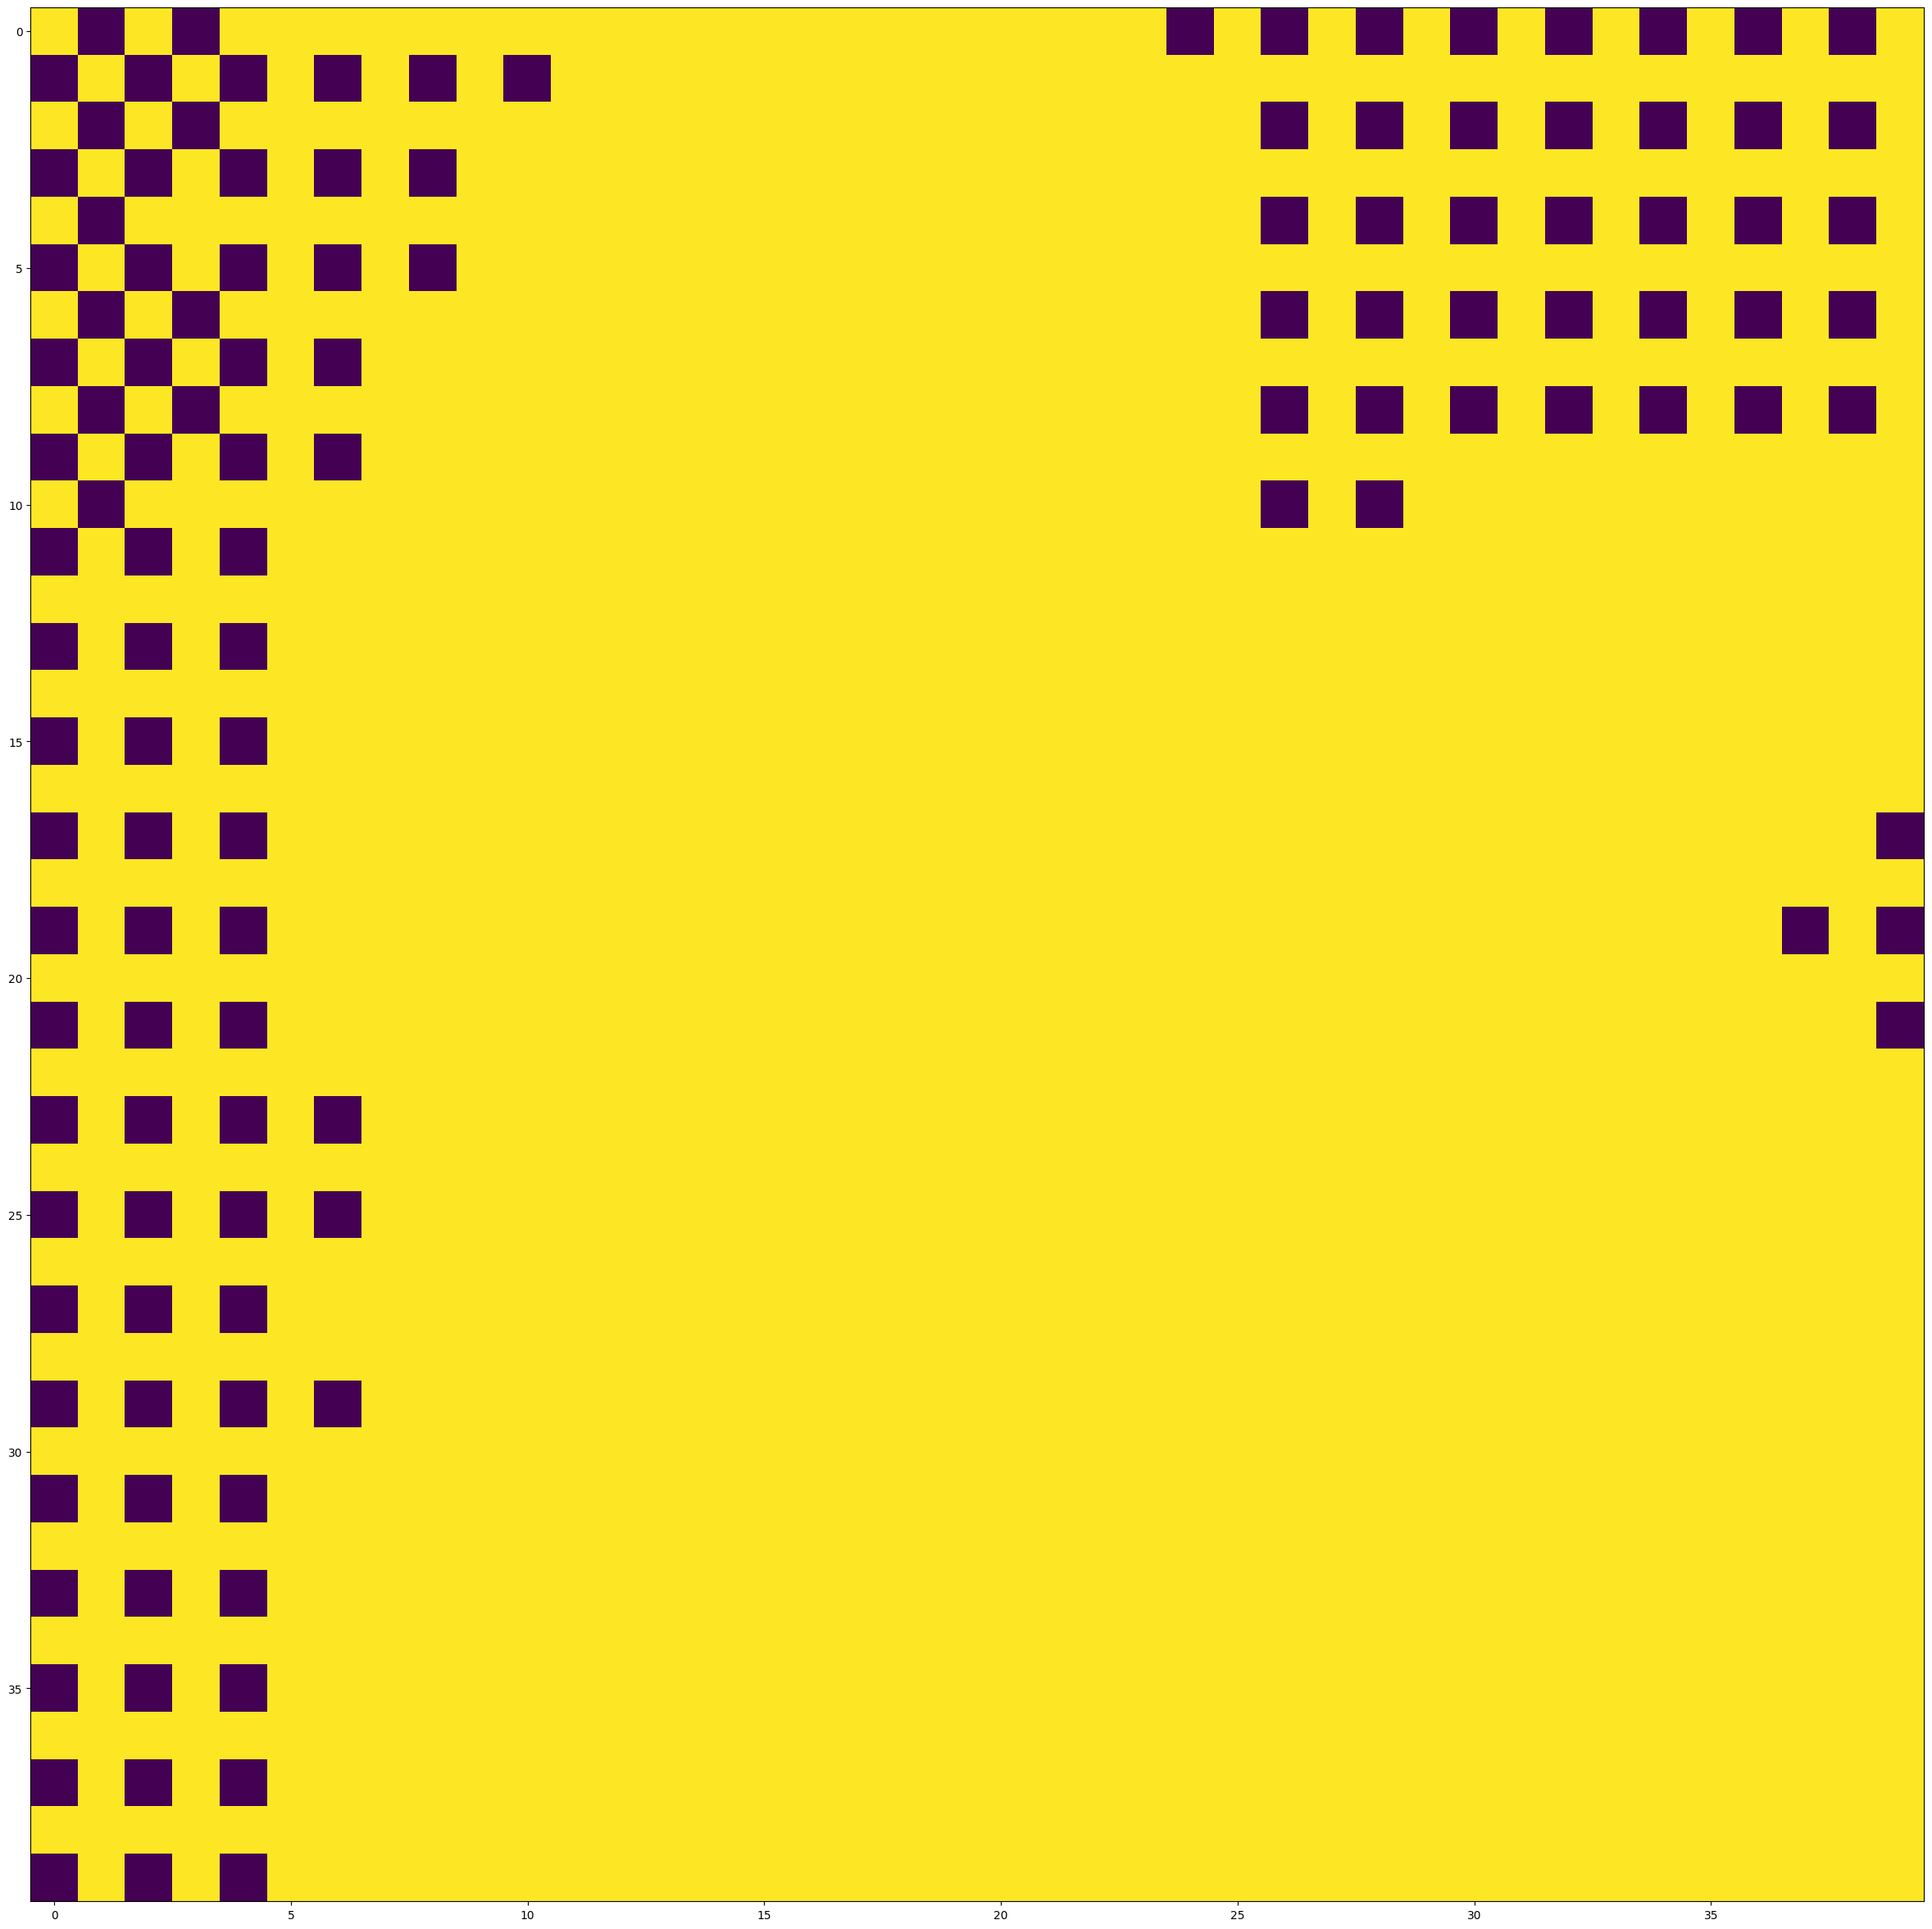

In [41]:
# --------------------------------- PLOT MAP --------------------------------- #
import matplotlib.pyplot as plt

plt.figure(figsize=(30, 30))
plt.imshow(maze)
plt.show()